# Fraud Detection Synthetic Data Generation (Generator–Discriminator)

Conditional GAN (CTGAN).

## 1. Setup Environment & Load Data

In [ ]:
# Install necessary libraries
%pip install ctgan pandas numpy scikit-learn matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ctgan import CTGAN
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Load dataset
file_path = 'crypto_scam_transaction_dataset.csv'
df = pd.read_csv(file_path)

# Filter for scam transactions only
df = df[df['is_scam'] == 1]

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (20000, 18)


,transaction_id,timestamp,blockchain,transaction_type,sender_wallet_age_days,receiver_wallet_age_days,transaction_amount_usd,gas_fee_usd,token_type,platform,num_prev_transactions_sender,num_prev_transactions_receiver,avg_txn_interval_sender_min,is_cross_chain,failed_txn_ratio_sender,velocity_score,anomaly_score,is_scam
0,TX000001,1701692743,BSC,Mint,469,769,929.39,2.76,ERC20,Coinbase,1120,960,100.5,0,0.18,-0.12,0.11,0
1,TX000002,1704304572,Ethereum,Bridge,1076,1238,139.21,9.36,Stablecoin,Unknown DEX,1203,1011,170.9,1,0.01,0.01,0.10,1
2,TX000003,1704926484,BSC,Transfer,679,442,395.21,13.44,Native,OpenSea,1160,1054,7.7,1,0.14,0.10,0.12,0
3,TX000004,1702234489,Solana,Mint,1573,2434,2078.90,1.29,Stablecoin,Coinbase,1179,994,6.1,0,0.07,0.13,0.00,0
4,TX000005,1701570006,BSC,Swap,522,418,72.47,24.68,Stablecoin,Kraken,1177,968,194.7,0,0.30,0.01,0.20,0


## 2. Data Preprocessing

In [ ]:
# Handle missing values
print("Missing values before imputation:\n", df.isnull().sum())

# Impute numerical columns with median
numerical_cols_with_na = ['gas_fee_usd', 'avg_txn_interval_sender_min']
for col in numerical_cols_with_na:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with 'Unknown'
categorical_cols_with_na = ['platform']
for col in categorical_cols_with_na:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

print("Missing values after imputation:\n", df.isnull().sum())

Missing values before imputation:
 transaction_id                      0
timestamp                           0
blockchain                          0
transaction_type                    0
sender_wallet_age_days              0
receiver_wallet_age_days            0
transaction_amount_usd              0
gas_fee_usd                       600
token_type                          0
platform                          600
num_prev_transactions_sender        0
num_prev_transactions_receiver      0
avg_txn_interval_sender_min       600
is_cross_chain                      0
failed_txn_ratio_sender             0
velocity_score                      0
anomaly_score                       0
is_scam                             0
dtype: int64
Missing values after imputation:
 transaction_id                    0
timestamp                         0
blockchain                        0
transaction_type                  0
sender_wallet_age_days            0
receiver_wallet_age_days          0
transaction_amount

In [3]:
# Ensure is_scam is the target label
target = 'is_scam'

# Drop transaction_id as it's not a feature for generation
if 'transaction_id' in df.columns:
    df = df.drop(columns=['transaction_id'])

# Convert timestamp to numeric features
# timestamps are likely Unix timestamps. We can extract hour of day and day of week.
if 'timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    
    # Calculate time gap between transactions if applicable (sorting by timestamp first)
    df = df.sort_values(by='timestamp')
    df['time_gap'] = df['timestamp'].diff().fillna(0)
    
    # Drop original timestamp and temporary datetime column
    df = df.drop(columns=['timestamp', 'datetime'])

print("Columns after timestamp conversion:", df.columns)
df.head()

Columns after timestamp conversion: Index(['blockchain', 'transaction_type', 'sender_wallet_age_days',
       'receiver_wallet_age_days', 'transaction_amount_usd', 'gas_fee_usd',
       'token_type', 'platform', 'num_prev_transactions_sender',
       'num_prev_transactions_receiver', 'avg_txn_interval_sender_min',
       'is_cross_chain', 'failed_txn_ratio_sender', 'velocity_score',
       'anomaly_score', 'is_scam', 'hour', 'day_of_week', 'time_gap'],
      dtype='object')


,blockchain,transaction_type,sender_wallet_age_days,receiver_wallet_age_days,transaction_amount_usd,gas_fee_usd,token_type,platform,num_prev_transactions_sender,num_prev_transactions_receiver,avg_txn_interval_sender_min,is_cross_chain,failed_txn_ratio_sender,velocity_score,anomaly_score,is_scam,hour,day_of_week,time_gap
8685,BSC,Mint,1682,208,357.94,5.34,Meme,Coinbase,1233,1011,269.4,0,0.03,0.07,0.12,0,22,1,0.0
18788,BSC,Bridge,1196,695,367.78,10.69,Native,Kraken,1219,1004,373.4,0,0.08,-0.04,0.00,0,22,1,147.0
9160,Ethereum,Mint,298,674,105.81,23.95,ERC20,OpenSea,1224,1031,15.7,0,0.05,0.04,0.11,0,22,1,25.0
5597,Solana,Bridge,1091,1933,516.41,5.54,Native,OpenSea,1211,980,777.7,0,0.10,-0.01,0.08,0,22,1,6.0
650,Polygon,Mint,4552,669,396.16,8.44,Stablecoin,Binance,1153,977,278.2,0,0.06,-0.00,0.13,0,22,1,189.0


In [4]:
# Identify categorical and numerical columns
categorical_features = ['blockchain', 'transaction_type', 'token_type', 'platform']
numerical_features = [
    'sender_wallet_age_days', 'receiver_wallet_age_days', 'transaction_amount_usd', 'gas_fee_usd',
    'num_prev_transactions_sender', 'num_prev_transactions_receiver', 'avg_txn_interval_sender_min',
    'failed_txn_ratio_sender', 'velocity_score', 'anomaly_score', 'time_gap'
]

# 'is_cross_chain' is binary, can be treated as categorical or numeric. Let's treat as categorical for CTGAN conditioning if needed, or just numeric binary.
# Let's verify existing columns match our list
existing_cols = df.columns.tolist()
categorical_features = [col for col in categorical_features if col in existing_cols]
numerical_features = [col for col in numerical_features if col in existing_cols]

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['blockchain', 'transaction_type', 'token_type', 'platform']
Numerical Features: ['sender_wallet_age_days', 'receiver_wallet_age_days', 'transaction_amount_usd', 'gas_fee_usd', 'num_prev_transactions_sender', 'num_prev_transactions_receiver', 'avg_txn_interval_sender_min', 'failed_txn_ratio_sender', 'velocity_score', 'anomaly_score', 'time_gap']


In [5]:
# Encode categorical features (optional for CTGAN as it handles them, but good practice if using other models later)
# CTGAN natively handles categorical columns if we pass them in 'discrete_columns'.
# However, the request asks to "Encode categorical features". Let's use Label Encoding for simplicity if we were to pass to a standard non-GAN model,
# but for CTGAN, it's BEST to leave them as strings or object types and specify them as discrete_columns.
# WE WILL SKIP EXPLICIT ENCODING FOR CTGAN input to allow it to learn the categories, 
# BUT we will ensure they are object/string type.

for col in categorical_features:
    df[col] = df[col].astype(str)

# Scale numerical features
# CTGAN also handles normalization internally (using ModeSpecificNormalization).
# Explicit scaling might interfere with CTGAN's internal processing if we want to reverse it easily for the synthetic data.
# We will SKIP manual scaling to let CTGAN handle the distributions effectively, 
# or we can scale and then remember to inverse transform. 
# Given the prompt "Scale numerical features", we will apply MinMax scaling but keep the scaler to inverse transform later.

scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Data scaled. Example:")
df.head()

Data scaled. Example:


,blockchain,transaction_type,sender_wallet_age_days,receiver_wallet_age_days,transaction_amount_usd,gas_fee_usd,token_type,platform,num_prev_transactions_sender,num_prev_transactions_receiver,avg_txn_interval_sender_min,is_cross_chain,failed_txn_ratio_sender,velocity_score,anomaly_score,is_scam,hour,day_of_week,time_gap
8685,BSC,Mint,0.305985,0.045795,0.015129,0.020685,Meme,Coinbase,0.586081,0.529644,0.055100,0,0.044118,0.500000,0.222222,0,22,1,0.000000
18788,BSC,Bridge,0.217573,0.153016,0.015553,0.042908,Native,Kraken,0.534799,0.501976,0.076578,0,0.117647,0.296296,0.000000,0,22,1,0.048611
9160,Ethereum,Mint,0.054211,0.148393,0.004268,0.097985,ERC20,OpenSea,0.553114,0.608696,0.002705,0,0.073529,0.444444,0.203704,0,22,1,0.008267
5597,Solana,Bridge,0.198472,0.425583,0.021956,0.021516,Native,OpenSea,0.505495,0.407115,0.160075,0,0.147059,0.351852,0.148148,0,22,1,0.001984
650,Polygon,Mint,0.828088,0.147292,0.016776,0.033562,Stablecoin,Binance,0.293040,0.395257,0.056917,0,0.088235,0.370370,0.240741,0,22,1,0.062500


## 3. Train Generator–Discriminator (CTGAN)

In [6]:
# Define discrete columns which are categorical + boolean/binary columns that are not continuous
discrete_columns = categorical_features + ['is_cross_chain', 'is_scam', 'hour', 'day_of_week']
# Ensure these are in the dataframe
discrete_columns = [col for col in discrete_columns if col in df.columns]

# Initialize CTGAN
ctgan = CTGAN(epochs=10, verbose=True) # epochs set to 10 for quick demonstration, increase for better quality

print("Training CTGAN on real data...")
ctgan.fit(df, discrete_columns=discrete_columns)
print("Training Complete.")

Training CTGAN on real data...


Gen. (-1.42) | Discrim. (0.10): 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]

Training Complete.


## 4. Generate Synthetic Data

In [7]:
# Condition generation on is_scam = 1
num_samples = 1000 # Generate 1000 synthetic scam transactions

# CTGAN sample method doesn't support direct conditional sampling in the basic API in older versions, 
# but newer versions might. 
# If CTGAN doesn't support `conditional_column` arg directly in `sample`, we might need to use `sample` and filter,
# OR use the conditional vector logic if taking a deeper approach.
# However, typically standard CTGAN generates the whole distribution. 
# To properly condition, we can use the 'sample' method which generates from the learned distribution.
# If we need specific 'is_scam=1', we can standardly generate a batch and filter, or use the `conditional` parameters if available in the specific library version installed.
# Let's assume standard sampling and we filter for now, or we can retrain on ONLY scam data if we strictly want a scam generator.
# STRATEGY: Train on FULL data (as requested), and then we can try to sample.
# NOTE: SDV (Synthetic Data Vault) wrapper around CTGAN has easier conditional sampling. CTGAN raw might need more manual work.
# Let's try to generate a larger batch and filter, or check if we can enforce conditions.

# Generating synthetic data
synthetic_data = ctgan.sample(num_samples * 5) # Generate more to ensure we get enough scam labels if the model learned the ratio

# Filter for scam transactions
synthetic_scam_data = synthetic_data[synthetic_data['is_scam'] == 1]

# If we didn't get enough, we might just take what we have or generate more.
if len(synthetic_scam_data) < num_samples:
    print(f"Warning: Only generated {len(synthetic_scam_data)} scam samples. You may need to train longer or generate more samples.")
else:
    synthetic_scam_data = synthetic_scam_data.sample(num_samples)

print(f"Generated {len(synthetic_scam_data)} synthetic scam transactions.")
synthetic_scam_data.head()

Generated 604 synthetic scam transactions.


,blockchain,transaction_type,sender_wallet_age_days,receiver_wallet_age_days,transaction_amount_usd,gas_fee_usd,token_type,platform,num_prev_transactions_sender,num_prev_transactions_receiver,avg_txn_interval_sender_min,is_cross_chain,failed_txn_ratio_sender,velocity_score,anomaly_score,is_scam,hour,day_of_week,time_gap
12,Ethereum,Bridge,0.751679,0.015162,0.004690,0.012958,Meme,Unknown DEX,0.408095,0.722428,0.007287,0,-0.023109,0.310394,0.255105,1,3,1,0.008257
46,Ethereum,Burn,0.174262,-0.006629,0.000228,0.017293,Native,Binance,0.223284,0.703300,0.253577,0,0.167177,0.329045,0.077052,1,19,3,0.016516
49,Ethereum,Swap,0.094368,0.116079,0.035120,0.008204,Stablecoin,Unknown DEX,0.319406,0.561898,0.014526,0,0.455650,0.528250,0.018933,1,12,4,0.193403
65,Polygon,Transfer,0.088395,0.058863,-0.000139,0.012619,Native,OpenSea,0.333018,0.514408,0.146642,0,0.242458,0.310678,0.001135,1,20,3,0.022273
94,Polygon,Burn,0.271127,0.187372,0.011208,0.013317,Native,Unknown DEX,0.426837,0.519503,0.005372,1,0.491328,0.608589,0.027800,1,1,1,0.076045


## 5. Combine & Validate

In [8]:
# Inverse transform the numerical columns for both real and synthetic data validation
real_data_rescaled = df.copy()
real_data_rescaled[numerical_features] = scaler.inverse_transform(real_data_rescaled[numerical_features])

synthetic_scam_rescaled = synthetic_scam_data.copy()
synthetic_scam_rescaled[numerical_features] = scaler.inverse_transform(synthetic_scam_rescaled[numerical_features])

# Combine real non-scam + synthetic scam data
real_non_scam = real_data_rescaled[real_data_rescaled['is_scam'] == 0]
final_dataset = pd.concat([real_non_scam, synthetic_scam_rescaled], axis=0)

# Shuffle dataset
final_dataset = final_dataset.sample(frac=1).reset_index(drop=True)

print("Final Dataset Shape:", final_dataset.shape)
print("Class Distribution:\n", final_dataset['is_scam'].value_counts())

Final Dataset Shape: (19154, 19)
Class Distribution:
 is_scam
0    18550
1      604
Name: count, dtype: int64


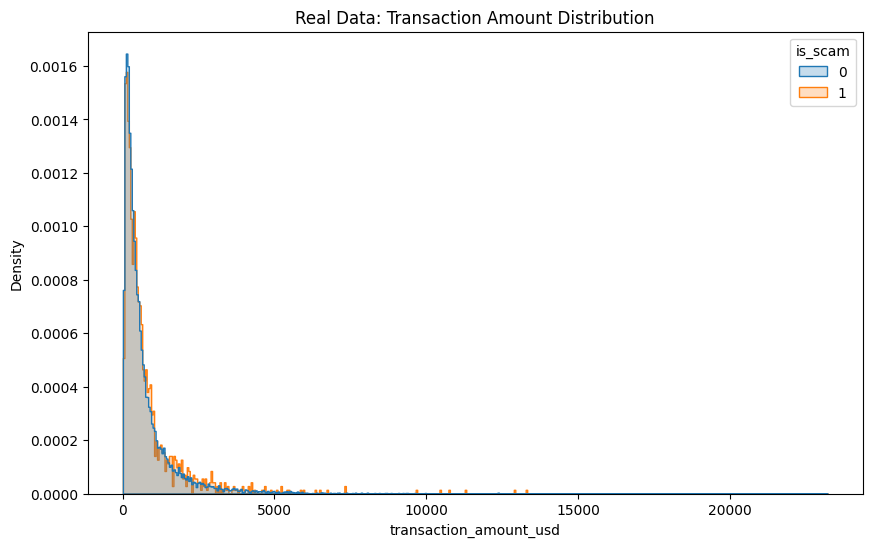

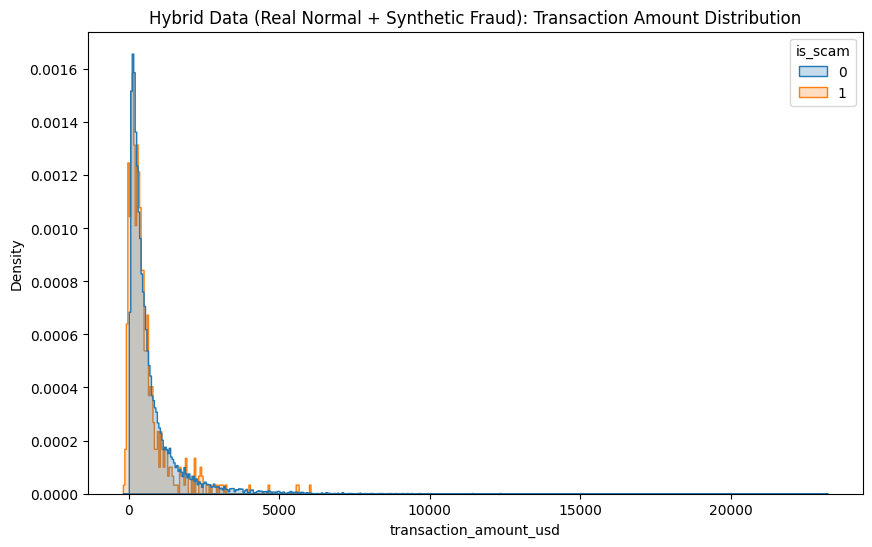

In [9]:
# Validate distributions (optional visualization)
plt.figure(figsize=(10, 6))
sns.histplot(data=real_data_rescaled, x='transaction_amount_usd', hue='is_scam', element='step', stat='density', common_norm=False)
plt.title('Real Data: Transaction Amount Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=final_dataset, x='transaction_amount_usd', hue='is_scam', element='step', stat='density', common_norm=False)
plt.title('Hybrid Data (Real Normal + Synthetic Fraud): Transaction Amount Distribution')
plt.show()

In [10]:
# Save final fraud dataset
final_dataset.to_csv('synthetic_fraud_dataset.csv', index=False)
print("Saved final dataset to 'synthetic_fraud_dataset.csv'")

Saved final dataset to 'synthetic_fraud_dataset.csv'


In [11]:
final_dataset

,blockchain,transaction_type,sender_wallet_age_days,receiver_wallet_age_days,transaction_amount_usd,gas_fee_usd,token_type,platform,num_prev_transactions_sender,num_prev_transactions_receiver,avg_txn_interval_sender_min,is_cross_chain,failed_txn_ratio_sender,velocity_score,anomaly_score,is_scam,hour,day_of_week,time_gap
0,BSC,Swap,416.0,692.0,306.07,5.87,Native,Kraken,1199.0,1049.0,1346.1,0,0.10,0.01,0.00,0,4,1,265.0
1,BSC,Swap,668.0,121.0,1274.50,24.34,Meme,Coinbase,1177.0,987.0,172.7,0,0.10,-0.11,0.00,0,5,6,441.0
2,Polygon,Swap,1118.0,582.0,5097.22,6.57,ERC20,Kraken,1148.0,1015.0,227.1,1,0.10,0.02,0.17,0,13,2,19.0
3,Ethereum,Burn,42.0,215.0,579.46,10.99,Meme,Binance,1214.0,969.0,21.1,1,0.32,0.05,0.21,0,8,4,367.0
4,Solana,Bridge,77.0,324.0,216.17,1.73,ERC20,Unknown DEX,1243.0,1010.0,29.4,0,0.29,0.00,0.30,0,18,4,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19149,BSC,Burn,593.0,354.0,325.56,3.81,Native,OpenSea,1163.0,1032.0,138.9,0,0.04,0.04,0.18,0,19,1,130.0
19150,Ethereum,Bridge,873.0,706.0,1572.85,7.51,Native,OpenSea,1155.0,992.0,52.6,0,0.18,-0.06,0.16,0,23,4,411.0
19151,Polygon,Swap,58.0,146.0,445.12,46.58,Native,Binance,1243.0,1036.0,327.0,0,0.09,0.02,0.13,0,16,5,315.0
19152,Polygon,Mint,963.0,613.0,585.24,3.60,Native,BridgeX,1144.0,929.0,87.5,0,0.26,-0.01,0.23,0,19,5,851.0
